In [1]:
import numpy as np
import scipy.sparse
import pandas as pd
pd.set_option("display.max_columns", None)
import time
import datetime
from sklearn import metrics
from scipy.sparse import coo_matrix, csc_matrix, csr_matrix
import tensorflow as tf
import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub
import tensorflow_transform as tft

from tqdm import tqdm
tqdm.pandas()

In [2]:
from google.cloud import bigquery
import gcsfs

client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: res-nbcupea-dev-ds-sandbox-001


In [3]:
def focal_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tfa.losses.sigmoid_focal_crossentropy(y_true, y_pred, alpha=0.75, gamma=3.0)


In [4]:
# Load the model
model_path = {}
#model_path["concat_before"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_5/Trainer/model/23992/serving_model_dir"
model_path["concat_both"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_6/Trainer/model/24002/serving_model_dir"
#model_path["concat_after"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_5/Trainer/model/23984/serving_model_dir"
#model = tf.saved_model.load(model_path)

In [5]:
# Load the vocab
tags_list_dict = {}
#tags_list_dict["concat_before"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_5/Transform/transform_graph/23971/transform_fn/assets/tags"
tags_list_dict["concat_both"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_6/Transform/transform_graph/24000/transform_fn/assets/tags"
#tags_list_dict["concat_after"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_5/Transform/transform_graph/23971/transform_fn/assets/tags"
fs = gcsfs.GCSFileSystem(project="res-nbcupea-dev-ds-sandbox-001")
for key, path in tags_list_dict.items():
    if path == "": continue
    with fs.open(path, "r") as fid:
        tags_list = fid.read().split("\n")
    tags_list = [tag for tag in tags_list if tag != ""]
    tags_list_dict[key] = tags_list
tags_list

['Howard the Duck',
 'Movie',
 'spa',
 'Musical comedy',
 'Film set',
 'Episode',
 'Love at first sight',
 'Unusual romance',
 'Magic and Fantasy',
 '1970s',
 'Community member',
 'Care-a-lot',
 'Amusing',
 'Father/daughter relationship',
 'Time travel',
 'Scientific experiments',
 'Unlikely criminal',
 'Unusual behavior',
 'Rise to stardom',
 'Little girl',
 'Home ownership',
 'Showdown',
 'Unhappy marriage',
 'Grandparent/child relationship',
 'Fiction writing',
 'Sports and Martial Arts',
 'Post-traumatic stress disorder',
 'Television star',
 'Old West myths',
 'Killer dolls',
 'Politics & Government',
 'Social injustice',
 'Witnessing murder',
 'Meaning of life',
 'R&B Music',
 'Family life',
 'New town',
 'North America',
 'Gay and Lesbian',
 'Eternal youth',
 'High-school teacher',
 'Museum of Modern Art',
 'Failing business',
 'Europe',
 "King's Cross Station",
 'Genpei War',
 'Radio host',
 'Fear',
 'Restaurant owner',
 'Personal assistant',
 'Great White Hunter',
 'Personal v

# Evaluation on the content-to-content recommendations

In [6]:
TITLES_QUERY_titles = """
    WITH titles_data AS (
        SELECT DISTINCT
            TitleDetails_title, 
            TitleType, 
            cid.content_ordinal_id,
            STRING_AGG(DISTINCT TitleDetails_longsynopsis, ' ') as TitleDetails_longsynopsis,
        FROM `res-nbcupea-dev-ds-sandbox-001.metadata_enhancement.ContentMetadataView` cmv
        LEFT JOIN `res-nbcupea-dev-ds-sandbox-001.recsystem.ContentOrdinalId` cid
            ON LOWER(cmv.TitleDetails_title) = LOWER(cid.program_title)
        WHERE 
            TitleDetails_longsynopsis IS NOT NULL
            AND cid.content_ordinal_id IS NOT NULL
        GROUP BY 
            TitleDetails_title, 
            TitleType,
            cid.content_ordinal_id
        )
    SELECT TitleDetails_title, LOWER(TitleDetails_title) AS title, TitleType, content_ordinal_id, TitleDetails_longsynopsis, 
    FROM titles_data
"""
df_titles = client.query(TITLES_QUERY_titles) \
                        .to_dataframe() \
                        .drop_duplicates(subset=['TitleDetails_title']) \
                        .reset_index(drop=True)

    
df_titles

,TitleDetails_title,title,TitleType,content_ordinal_id,TitleDetails_longsynopsis
0,Half Baked,half baked,Movie,1943,"Potheads (Dave Chappelle, Guillermo Diaz, Jim ..."
1,Harry Potter and the Prisoner of Azkaban,harry potter and the prisoner of azkaban,Movie,1461,The young wizard (Daniel Radcliffe) and his fr...
2,Mad About Mambo,mad about mambo,Movie,530,A soccer player (William Ash) takes mambo less...
3,Hit by Lightning,hit by lightning,Movie,422,A nerdy restaurant manager (Jon Cryer) unexpec...
4,Battle of Los Angeles,battle of los angeles,Movie,138,"In 1942, the United States engages with an uni..."
...,...,...,...,...,...
2266,Jimmy announces BTS week,jimmy announces bts week,Programme,1418,Jimmy announces a week of special BTS performa...
2267,Cardi B explains her divorce,cardi b explains her divorce,Programme,1361,"The ""WAP"" rapper sets the record straight on I..."
2268,Jane Lynch talks Emmys at home,jane lynch talks emmys at home,Programme,1373,"The ""Marvelous Mrs. Maisel"" star shows off her..."
2269,Compulsion,compulsion,Programme,1366,Cologne for the obsessive-compulsive.


In [8]:
input_data = {"synopsis": df_titles['TitleDetails_longsynopsis'].values[:, None], 
              "title": df_titles['TitleDetails_longsynopsis'].values[:, None]}
dataset = tf.data.Dataset.from_tensor_slices(input_data).batch(50)

# Looping over the models
for key, path in model_path.items():
    print(f"Loading model: {key}")
   
    model = tf.saved_model.load(path)
    res = []
    for batch in tqdm(dataset):
        transformed_features = model.tft_layer(batch)
        transformed_features["synopsis"] = transformed_features["synopsis"][:, None]
        y = model(transformed_features)
        res.append(y)
        
    res = list(tf.concat(res, axis=0).numpy())
    df_titles[f"{key}_predicted"] = res
    # Temporarily save the results
    df_titles.to_pickle("./scratch/explore_emd_09_titles_predicted_values.pkl", compression="gzip")

df_titles


Loading model: concat_both


  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 46/46 [06:37<00:00,  8.65s/it]


,TitleDetails_title,title,TitleType,content_ordinal_id,TitleDetails_longsynopsis,concat_both_predicted
0,Half Baked,half baked,Movie,1943,"Potheads (Dave Chappelle, Guillermo Diaz, Jim ...","[0.96665025, 0.69668686, 0.21260709, 0.5673733..."
1,Harry Potter and the Prisoner of Azkaban,harry potter and the prisoner of azkaban,Movie,1461,The young wizard (Daniel Radcliffe) and his fr...,"[0.89995754, 0.6867695, 0.23386756, 0.53130895..."
2,Mad About Mambo,mad about mambo,Movie,530,A soccer player (William Ash) takes mambo less...,"[0.92173594, 0.6004482, 0.2455765, 0.61635697,..."
3,Hit by Lightning,hit by lightning,Movie,422,A nerdy restaurant manager (Jon Cryer) unexpec...,"[0.9132371, 0.6260237, 0.16991213, 0.5591186, ..."
4,Battle of Los Angeles,battle of los angeles,Movie,138,"In 1942, the United States engages with an uni...","[0.96133935, 0.6809536, 0.20865232, 0.49299416..."
...,...,...,...,...,...,...
2266,Jimmy announces BTS week,jimmy announces bts week,Programme,1418,Jimmy announces a week of special BTS performa...,"[0.86310685, 0.2909394, 0.11334199, 0.32548058..."
2267,Cardi B explains her divorce,cardi b explains her divorce,Programme,1361,"The ""WAP"" rapper sets the record straight on I...","[0.9174168, 0.40742373, 0.0929026, 0.312441, 0..."
2268,Jane Lynch talks Emmys at home,jane lynch talks emmys at home,Programme,1373,"The ""Marvelous Mrs. Maisel"" star shows off her...","[0.79852486, 0.27777618, 0.1779846, 0.48377994..."
2269,Compulsion,compulsion,Programme,1366,Cologne for the obsessive-compulsive.,"[0.8306471, 0.26055026, 0.09764743, 0.31659508..."


## Plot the embeddings of some titles

In [9]:
important_titles = ["The Office", "30 Rock", "Punky Brewster", "Parks and Recreation", "WWE Monday Night RAW", 
            "Yellowstone", "Saturday Night Live", "Law & Order: Special Victims Unit", 
            "Law & Order: Organized Crime", "Mr. Mercedes", "Happy Feet Two", "Zombie Tidal Wave"]

key_tags = ["eng", "spa",
            'preschoolers (ages 2-4)', 'kids (ages 5-9)', 'tweens (ages 10-12)','teens (ages 13-14)',
            'older teens (ages 15+)','not for kids',
            "Action & Adventure", "Comedy","Horror", "Children's/Family Entertainment", "Sports", 
            "Animated", "Holiday", "Crime", 'News', 'Reality', 'Music', 'Christmas','Food','Travel','Fantasy',
            'Science fiction','History',
           ]

In [ ]:
df_titles = pd.read_pickle("./scratch/explore_emd_08_titles_predicted_values.pkl", compression="gzip")
df_titles

## Making Content to content recommendations

In [20]:
# Do the pairwise similarity
def cosine_sim(P):
    
    P = P / np.sqrt(np.sum(P**2, axis=1, keepdims=True))
    cos_sim_c2c = P @ P.T
    cos_sim_c2c = np.nan_to_num(cos_sim_c2c, nan=-1)
    return cos_sim_c2c

def kl_divergence(P):
    P = P / np.sum(P, axis=1, keepdims=True)
    H_p = -np.sum(P * np.log(P), axis=1, keepdims=True)
    H_p_q = -(P @ np.log(P.T))
    D_kl = H_p_q - H_p
    return D_kl

def js_divergence(P):
    D_kl = kl_divergence(P)
    return D_kl * 0.5 + D_kl.T * 0.5

similarity = {"cosine":{}}

for s in similarity:
    for key in model_path.keys():
        predicted = np.stack(df_titles[f"{key}_predicted"].values)
        similarity[s][key] = cosine_sim(predicted)
        
        # Slice out top 15 recommendations
        score = list(np.sort(similarity[s][key], axis=1)[:, ::-1][:, 1:(15+1)])
        sim_c2c_argsort = np.argsort(similarity[s][key], axis=1)[:, ::-1][:, 1:]
        titles = list(np.take(df_titles["TitleDetails_title"].values, sim_c2c_argsort[:, :15]))
        titles_type = list(np.take(df_titles["TitleType"].values, sim_c2c_argsort[:, :15]))
        synopsis = list(np.take(df_titles["TitleDetails_longsynopsis"].values, sim_c2c_argsort[:, :15]))
        content_id = list(np.take(df_titles["content_ordinal_id"].values, sim_c2c_argsort[:, :15]))
        dict_list = [{"TitleDetails_title": tt, "TitleType": ttype, "TitleDetails_longsynopsis": syn, "content_ordinal_id": cid, "score": sc} \
                     for tt, ttype, syn, cid, sc in zip(titles, titles_type, synopsis, content_id, score)]

        df_titles[f"{s}_{key}_top15"] = dict_list
        # Calculate a type match
        df_titles[f"{s}_{key}_type_match"] = (np.stack(titles_type) == df_titles["TitleType"][:, None]).mean(axis=1)
        
df_titles

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


,TitleDetails_title,title,TitleType,content_ordinal_id,TitleDetails_longsynopsis,concat_both_predicted,cosine_concat_both_top15,cosine_concat_both_type_match
0,Half Baked,half baked,Movie,1943,"Potheads (Dave Chappelle, Guillermo Diaz, Jim ...","[0.96665025, 0.69668686, 0.21260709, 0.5673733...","{'TitleDetails_title': ['The Town', 'Mad Money...",1.000000
1,Harry Potter and the Prisoner of Azkaban,harry potter and the prisoner of azkaban,Movie,1461,The young wizard (Daniel Radcliffe) and his fr...,"[0.89995754, 0.6867695, 0.23386756, 0.53130895...","{'TitleDetails_title': ['The Ninth Gate', 'Rob...",1.000000
2,Mad About Mambo,mad about mambo,Movie,530,A soccer player (William Ash) takes mambo less...,"[0.92173594, 0.6004482, 0.2455765, 0.61635697,...","{'TitleDetails_title': ['Relative Strangers', ...",1.000000
3,Hit by Lightning,hit by lightning,Movie,422,A nerdy restaurant manager (Jon Cryer) unexpec...,"[0.9132371, 0.6260237, 0.16991213, 0.5591186, ...","{'TitleDetails_title': ['Life of Crime', 'Alon...",1.000000
4,Battle of Los Angeles,battle of los angeles,Movie,138,"In 1942, the United States engages with an uni...","[0.96133935, 0.6809536, 0.20865232, 0.49299416...","{'TitleDetails_title': ['Apocalypse Pompeii', ...",1.000000
...,...,...,...,...,...,...,...,...
2266,Jimmy announces BTS week,jimmy announces bts week,Programme,1418,Jimmy announces a week of special BTS performa...,"[0.86310685, 0.2909394, 0.11334199, 0.32548058...",{'TitleDetails_title': ['Jeff Beck: Rock 'n' R...,0.866667
2267,Cardi B explains her divorce,cardi b explains her divorce,Programme,1361,"The ""WAP"" rapper sets the record straight on I...","[0.9174168, 0.40742373, 0.0929026, 0.312441, 0...",{'TitleDetails_title': ['The Paley Center Salu...,0.600000
2268,Jane Lynch talks Emmys at home,jane lynch talks emmys at home,Programme,1373,"The ""Marvelous Mrs. Maisel"" star shows off her...","[0.79852486, 0.27777618, 0.1779846, 0.48377994...","{'TitleDetails_title': ['Carson Kressley on ""R...",0.400000
2269,Compulsion,compulsion,Programme,1366,Cologne for the obsessive-compulsive.,"[0.8306471, 0.26055026, 0.09764743, 0.31659508...","{'TitleDetails_title': ['Wacky Glue', 'Thank Y...",0.933333


## Plotting out the distribution of cosine similarities

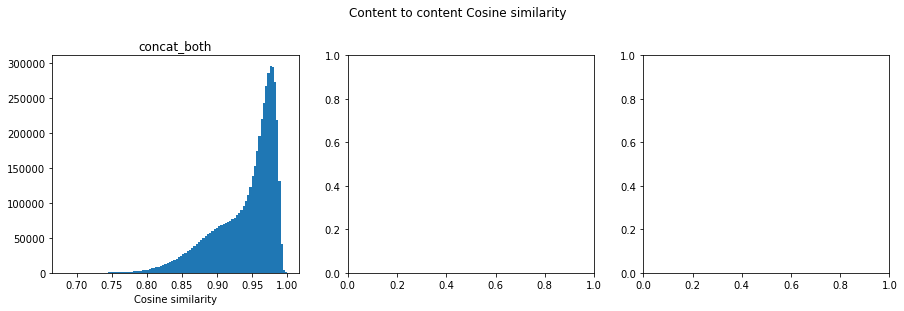

In [21]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, key in enumerate(model_path.keys()):
    ax = axs[i]
    ax.hist(np.sort(similarity["cosine"][key], axis=1)[:, ::-1][:, 1:].ravel(), bins=100) # remove cosine-sim with itself
    ax.set_xlabel("Cosine similarity")
    ax.set_title(key)
    
_ = fig.suptitle("Content to content Cosine similarity", y=1.05)

## Query some shows

In [22]:
# Do some quries
from IPython.display import display
def query_shows_c2c(df_titles, show_name, key="concat_after", sim_metric="cosine", show_res=True):
    pdf = df_titles.loc[df_titles["TitleDetails_title"]==show_name, :]
    pdf_query = pdf[["content_ordinal_id", "TitleDetails_title", "TitleType", "TitleDetails_longsynopsis"]]
    pdf_res = pd.DataFrame(pdf[f"{sim_metric}_{key}_top15"].values[0])
    if show_res:
        print("Query")
        display(pdf_query)
        print(f"Result: {sim_metric} {key}")
        display(pdf_res)
    
    return pdf_query, pdf_res
    

In [ ]:
for ti in important_titles:
    _ = query_shows_c2c(df_titles, ti, key="concat_before")


In [23]:
for ti in important_titles:
    _ = query_shows_c2c(df_titles, ti, key="concat_both")


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1859,1891,The Office,Programme,Michael tries to raise employee morale with a ...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Suits,Programme,Mike attempts to prove Rachel's innocence as a...,779,0.992307
1,Listing Impossible,Programme,A $30 million Tuscan-style castle sticks out l...,518,0.990236
2,Mr. Mayor,Programme,A mandatory staff meeting derails plans for th...,2014,0.989864
3,Homefront,Programme,Louise is still reeling from the shock of seei...,1733,0.989668
4,Father of the Pride,Programme,Larry tries to satisfy Kate's desire for spont...,341,0.989109
5,The Real Housewives of Beverly Hills,Programme,Cast members reminisce about the season. Unair...,1309,0.988973
6,3rd Rock From the Sun,Programme,Stranded by a snowstorm on their way to Chicag...,1203,0.988031
7,The Office: Superfan Episodes,Programme,"After Jan busts Michael for having a ""movie Mo...",1968,0.987992
8,Hitmen,Programme,It's Fran's birthday and Jamie wants to celebr...,1189,0.987918
9,American Greed,Programme,A US Military contractor loots his company of ...,86,0.987828


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1749,17,30 Rock,Programme,Liz tries to boost morale by taking the show o...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,A.P. Bio,Programme,When budget cuts threaten to gut Whitlock and ...,36,0.995186
1,George Lopez,Programme,Angie plans a surprise birthday party for Geor...,379,0.995098
2,Mr. Mayor,Programme,A mandatory staff meeting derails plans for th...,2014,0.994711
3,The Office: Superfan Episodes,Programme,"After Jan busts Michael for having a ""movie Mo...",1968,0.994627
4,Cheers,Programme,Diane's scorn for Sam's choice of female compa...,228,0.994323
5,Council of Dads,Programme,Anthony arrives at the Perry home to find Robi...,261,0.993979
6,Perfect Harmony,Programme,At the regional choir competition in Lexington...,632,0.993735
7,Transplant,Programme,An incident at work causes Bash to second-gues...,1267,0.993723
8,Sweet Home,Programme,When she discovers the state of Pumps' living ...,787,0.993427
9,Intelligence,Programme,Coming Soon A maverick NSA agent enlists the h...,1049,0.993110


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1853,656,Punky Brewster,Programme,Punky's decision to shoplift a Christmas gift ...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Wilfred,Programme,Adam and Sarah try to spend quality time toget...,2187,0.992935
1,The Munsters,Programme,Grandpa concocts a potion to provide instant t...,902,0.992791
2,The Goode Family,Programme,Helen is banned from a store when she is accus...,853,0.992575
3,The King of Queens,Programme,Doug and Carrie feel inadequate when they disc...,880,0.992256
4,My Life Me,Programme,Four teens try to fit in and make sense of lif...,1146,0.992228
5,Nurses,Programme,Keon assists a patient who goes into early lab...,1841,0.992050
6,Southern Charm Savannah,Programme,"In the aftermath of her house fire, Ashley con...",758,0.991789
7,Saved by the Bell: The College Years,Programme,Zack (Mark-Paul Gosselaar) takes a part-time j...,697,0.991759
8,Nina's World,Programme,Nina and her friends invent a game. Nina tries...,1423,0.991722
9,Five Bedrooms,Programme,Five singles purchase a house together and soo...,1199,0.991720


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1981,626,Parks and Recreation,Programme,When a neighboring town puts a fence around on...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Mr. Mercedes,Programme,Pete and Ida notice that Hodges is struggling;...,1562,0.993366
1,Kourtney & Kim Take New York,Programme,Kim has a new shopping buddy; Kourtney questio...,492,0.992758
2,Days of our Lives,Programme,Eli questions Lani about why she threw a rock ...,275,0.992671
3,Chicago Fire,Programme,Casey and Dawson get caught in what may be a p...,230,0.992371
4,Necessary Roughness,Programme,New management at the Hawks turns Dani's world...,594,0.992202
5,30 Rock,Programme,Liz tries to boost morale by taking the show o...,17,0.992166
6,A.P. Bio,Programme,When budget cuts threaten to gut Whitlock and ...,36,0.992029
7,The Office: Superfan Episodes,Programme,"After Jan busts Michael for having a ""movie Mo...",1968,0.991745
8,Keeping Up With the Kardashians,Programme,Kim poses for a Playboy photo shoot. An annive...,1301,0.991728
9,Southern Charm,Programme,"After another fundraiser goes awry, Thomas rea...",756,0.991226


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2046,2301,WWE Monday Night RAW,Programme,Shawn Michaels battles Billy Gunn. Shawn Micha...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,WrestleMania,Programme,The historic first WrestleMania from Madison S...,2295,0.994169
1,WWE NXT,Programme,"Andrade ""Cien"" Almas defends the NXT Champions...",2341,0.991219
2,The Titan Games,Programme,The competition continues in the Eastern divis...,935,0.990771
3,Royal Rumble,Programme,Twenty Superstars compete in the first-ever Ro...,2294,0.990475
4,WWE Untold,Programme,AJ Styles shares his journey growing up as the...,1212,0.990144
5,Stone Cold Steve Austin: The Broken Skull Sess...,Programme,"""Stone Cold"" Steve Austin sits down with forme...",1215,0.987264
6,American Ninja Warrior Junior,Programme,"All-star ninjas Drew Drechsel, Natalie Duran a...",90,0.986824
7,WWE Ruthless Aggression,Programme,With Vince McMahon's declaration of Ruthless A...,1216,0.986823
8,WWE The Bump,Programme,Seth Rollins discusses his return at Royal Rum...,2363,0.986358
9,WWE Friday Night SmackDown,Programme,Roman Reigns vs. Nakamura for the Intercontine...,2292,0.985866


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1800,1017,Yellowstone,Programme,"John Dutton, patriarch of a Montana ranching f..."


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Chicago Fire,Programme,Casey and Dawson get caught in what may be a p...,230,0.994053
1,Noughts + Crosses,Programme,Callum and Sephy try to get some alone time; m...,1272,0.993089
2,Brooklyn Nine-Nine,Programme,Terry takes cues from Jake while on his first ...,1299,0.993040
3,Roger Ramjet,Programme,Dr. Frank N. Schwein needs help with Seymour; ...,684,0.992666
4,Bluff City Law,Programme,"Sydney, Elijah and Briana take on a pill mill ...",183,0.991186
5,Psych,Programme,"Wanting to be appointed to Chief of Police, La...",652,0.991106
6,Sunnyside,Programme,Garrett and Griselda suspect Hakim is involved...,783,0.990518
7,This Is Us,Programme,The Pearsons rally around Kate as she undergoe...,1082,0.990515
8,The Capture,Programme,The stakes intensify for Shaun as he's interro...,1074,0.990454
9,Ray Donovan,Programme,Bunchy has a violent encounter and Ray must ha...,1064,0.990430


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1562,693,Saturday Night Live,Programme,Holiday sketches from past years include appea...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,The Carol Burnett Show,Programme,"Guests: Jonathan Winters, Barbara Eden and Leo...",817,0.992768
1,The Tonight Show Starring Jimmy Fallon,Programme,Actor Steve Buscemi; actress Zoey Deutch; Just...,936,0.992333
2,Late Night With Seth Meyers,Programme,Actor John Krasinski; actress Regina Hall; Bon...,503,0.990189
3,The At-Home Variety Show Featuring Seth MacFar...,Programme,Larry Wilmore’s Show Within a Show. Masterclas...,804,0.989749
4,The Kelly Clarkson Show,Programme,"Kelly covers Bruno Mars' ""Finesse""; Tim Allen;...",878,0.988691
5,Hollywood Game Night,Programme,"Celebrity contestants include Gina Rodriguez, ...",428,0.988373
6,Inside Comedy,Programme,David Steinberg interviews Sarah Silverman and...,2147,0.987928
7,Talk Stoop,Programme,"Celebrities, artists and influencers stop by t...",1197,0.987298
8,Big Freedia: Queen of Bounce,Programme,Big Freedia performs in Rio de Janeiro. Big Fr...,1597,0.987044
9,It's Showtime at the Apollo,Programme,"Music: Mary J. Blige (""I'm Goin' Down""), Fredd...",2084,0.987037


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2122,506,Law & Order: Special Victims Unit,Programme,When detective Benson gets into the middle of ...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,In Ice Cold Blood,Programme,A loving grandmother from a traveling communit...,458,0.994756
1,Three Days to Live,Programme,21-year-old Anita Wooldridge is kidnapped from...,955,0.994333
2,Dateline,Programme,The murder of a California mother beloved by f...,271,0.993570
3,Law & Order,Programme,A cosmetics tycoon (Lucie Arnaz) is involved i...,504,0.992878
4,Killerpost,Programme,A girl disappears one week after accepting a s...,485,0.992535
5,Murder for Hire,Programme,A teenage mother starts to make questionable c...,585,0.992478
6,Law & Order: Criminal Intent,Programme,When a TV host is bludgeoned with a champagne ...,505,0.992439
7,Columbo,Programme,Evidence points to an innocent woman after an ...,252,0.992084
8,Monk,Programme,Monk does whatever he can to solve the case wh...,573,0.991880
9,Snapped,Programme,A parking lot shooting in the dead of night le...,744,0.991695


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2270,2325,Law & Order: Organized Crime,Programme,Elliot Stabler returns to the NYPD to take on ...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Corbin Nash,Movie,A New York City cop transfers to Los Angeles t...,259,0.994614
1,Imperium,Movie,An idealistic FBI agent (Daniel Radcliffe) goe...,1030,0.994281
2,Elephant White,Movie,An assassin has a midlife crisis after his con...,318,0.993632
3,Recoil,Movie,A cop turns into a vigilante and seeks revenge...,2015,0.993479
4,Miami City Vice,Programme,Detective Joe Schillaci begins his new job hea...,1533,0.993405
5,White House Down,Movie,While on a tour of the White House with his yo...,2396,0.993337
6,Vertigo,Movie,A former San Francisco detective (James Stewar...,986,0.993177
7,Dark Sense,Movie,A young man who has exceptional powers hires a...,2044,0.992851
8,Escape From New York,Movie,A hardened criminal is offered a pardon if he ...,1162,0.992842
9,Wonderland,Movie,"In debt and addicted to drugs, porn star John ...",1792,0.992703


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1896,1562,Mr. Mercedes,Programme,Pete and Ida notice that Hodges is struggling;...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Days of our Lives,Programme,Eli questions Lani about why she threw a rock ...,275,0.994644
1,Parks and Recreation,Programme,When a neighboring town puts a fence around on...,626,0.993366
2,Ray Donovan,Programme,Bunchy has a violent encounter and Ray must ha...,1064,0.992838
3,Frasier,Programme,Frasier drives his family crazy when the death...,371,0.992485
4,Bluff City Law,Programme,"Sydney, Elijah and Briana take on a pill mill ...",183,0.992367
5,Save Me,Programme,Nelly sets off to find his estranged daughter ...,1268,0.992263
6,Chicago Fire,Programme,Casey and Dawson get caught in what may be a p...,230,0.992104
7,Grace Under Fire,Programme,Quentin (Jon Paul Steuer) runs away to see his...,1205,0.991760
8,Brooklyn Nine-Nine,Programme,Terry takes cues from Jake while on his first ...,1299,0.991620
9,Kourtney & Kim Take New York,Programme,Kim has a new shopping buddy; Kourtney questio...,492,0.991015


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1356,2320,Happy Feet Two,Movie,"Reluctant to dance, the son of Mumble (Elijah ..."


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Princess and the Pony,Movie,A young princess (Fiona Perry) travels to Amer...,651,0.989850
1,Americano,Movie,When a gang of bully birds threaten his father...,94,0.987727
2,A Winter Wedding,Movie,Hallie and Lucas plan the tropical beach weddi...,1613,0.987282
3,Barney's Great Adventure,Movie,"The big, purple dinosaur and his young friends...",136,0.986885
4,Despicable Me,Movie,As he tries to execute a fiendish plot to stea...,2316,0.986806
5,Shelby: The Dog Who Saved Christmas,Movie,An orphaned dog (Rob Schneider) is taken in by...,726,0.986497
6,Shelby,Movie,An orphaned dog (Rob Schneider) is taken in by...,725,0.986497
7,Moon Man,Movie,The Moon Man grabs a shooting star as it goes ...,579,0.986423
8,The Wolf Man,Movie,"Bitten by a werewolf, an aristocrat (Lon Chane...",949,0.986242
9,Dear Santa,Movie,"Crystal, a rich party girl, finds a little gir...",280,0.986139


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
521,1574,Zombie Tidal Wave,Movie,Zombies wreak bloodthirsty havoc after a tidal...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Android Cop,Movie,A cop and his android partner enter a forbidde...,97,0.991653
1,Beneath the Harvest Sky,Movie,Two teenage friends take different paths to re...,1805,0.990775
2,"People, Places, Things",Movie,A graphic novelist /professor (Jemaine Clement...,630,0.989959
3,Big Fan,Movie,A football fan (Patton Oswalt) meets his idol ...,166,0.989728
4,You're Next,Movie,"Members of an estranged, upper-class family mu...",1088,0.988991
5,House of the Dead,Movie,"Party-bound young people (Jonathan Cherry, Tyr...",438,0.988758
6,Coldwater,Movie,Tragic events send a teenage boy to a juvenile...,2180,0.988665
7,Starred Up,Movie,An explosive teenager runs into his equally vi...,763,0.988548
8,Monster High: Freaky Fusion,Movie,"During the Bite-Centennial, the ghouls travel ...",1117,0.988425
9,Silicon Cowboys,Movie,After three friends invent the Compaq portable...,2115,0.988279


In [ ]:
for ti in important_titles:
    _ = query_shows_c2c(df_titles, ti, key="concat_after")


In [ ]:
_ = query_shows_c2c(df_titles, "The Office", key="concat_before")

## Visualize embedded contents with TSNE

In [27]:
# Dimensionality reduce the embeddings
from sklearn.manifold import TSNE
def kl_distance(p, q):
    return np.sum(p * np.log((p+1E-12) / (q+1E-12)))

for key in model_path.keys():
    print(key)
    val = np.stack(df_titles[f"{key}_predicted"].values)
    tsne_xy = TSNE(n_components=2, metric="cosine", square_distances="legacy").fit_transform(val)
    df_titles[f"{key}_x"] = tsne_xy[:, 0]
    df_titles[f"{key}_y"] = tsne_xy[:, 1]
df_titles.to_pickle("./explore_emd_08_c2c_predicted_values-tsne.pkl")
df_titles

concat_before


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


concat_both


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


concat_after


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


,TitleDetails_title,title,TitleType,content_ordinal_id,TitleDetails_longsynopsis,concat_before_predicted,concat_both_predicted,concat_after_predicted,cosine_concat_before_top15,cosine_concat_before_type_match,cosine_concat_both_top15,cosine_concat_both_type_match,cosine_concat_after_top15,cosine_concat_after_type_match,concat_before_x,concat_before_y,concat_both_x,concat_both_y,concat_after_x,concat_after_y
0,Man on the Moon,man on the moon,Movie,538,Milos Forman's film spotlights Andy Kaufman's ...,"[0.81644434, 0.90579253, 0.15320522, 0.4928113...","[0.8284041, 0.905096, 0.20058607, 0.45802736, ...","[0.8212801, 0.8854742, 0.16610035, 0.4262186, ...",{'TitleDetails_title': ['Joel McHale: Live Fro...,1.000000,"{'TitleDetails_title': ['I Am Big Bird', 'The ...",1.000000,{'TitleDetails_title': ['The Kentucky Fried Mo...,1.000000,11.166300,-15.652939,7.383417,8.870411,18.750639,15.245512
1,Age of Dinosaurs,age of dinosaurs,Movie,52,A former firefighter fights to rescue his teen...,"[0.7035422, 0.9863275, 0.08182001, 0.49750206,...","[0.71488655, 0.98637944, 0.12275929, 0.4590722...","[0.71639156, 0.97941005, 0.15130031, 0.5399029...","{'TitleDetails_title': ['Zombie Night', 'Curse...",1.000000,"{'TitleDetails_title': ['Brother's Keeper', 'W...",1.000000,"{'TitleDetails_title': ['Neds', 'Coldwater', '...",1.000000,-18.692150,14.555692,-12.044270,14.903689,-22.114405,-10.628927
2,The Big Lebowski,the big lebowski,Movie,1153,"Bowling buddies (Jeff Bridges, John Goodman) b...","[0.8400246, 0.9725601, 0.061443575, 0.60232407...","[0.8737767, 0.97333544, 0.11291292, 0.570399, ...","[0.85491306, 0.9705054, 0.0812858, 0.59130585,...",{'TitleDetails_title': ['Telling Lies in Ameri...,1.000000,{'TitleDetails_title': ['Telling Lies in Ameri...,1.000000,{'TitleDetails_title': ['Telling Lies in Ameri...,1.000000,18.267637,-9.310962,4.476210,2.953112,9.003719,23.940203
3,The Front Page,the front page,Movie,849,The managing editor (Walter Matthau) of a 1920...,"[0.7750384, 0.97071934, 0.15157142, 0.5666047,...","[0.7901433, 0.97014254, 0.19608684, 0.54323006...","[0.7899858, 0.97068393, 0.1514504, 0.57636464,...","{'TitleDetails_title': ['Midnight Lace', 'The ...",1.000000,"{'TitleDetails_title': ['Midnight Lace', 'Raw ...",1.000000,"{'TitleDetails_title': ['Primary Colors', 'Edi...",1.000000,-13.410742,12.958163,9.308162,-24.759205,-1.434509,-0.093949
4,Middle Men,middle men,Movie,558,A Texas businessman (Luke Wilson) tries unsucc...,"[0.88433164, 0.97341317, 0.05437197, 0.5938839...","[0.90864223, 0.97640926, 0.073455505, 0.545751...","[0.8962843, 0.9673246, 0.08035563, 0.58995014,...","{'TitleDetails_title': ['Once Fallen', 'The To...",1.000000,"{'TitleDetails_title': ['Once Fallen', 'The To...",1.000000,"{'TitleDetails_title': ['Once Fallen', 'The To...",1.000000,17.546431,42.870502,-5.715060,-44.866188,-34.406223,22.046257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266,Reagan Jeans,reagan jeans,Programme,1424,Will shrink by 5 percent.,"[0.5537927, 0.9188018, 0.070349395, 0.3195026,...","[0.5911677, 0.9400158, 0.06304189, 0.27550107,...","[0.49115136, 0.9172866, 0.09860793, 0.46767575...",{'TitleDetails_title': ['It's Not Halloween Wi...,1.000000,{'TitleDetails_title': ['It's Not Halloween Wi...,1.000000,"{'TitleDetails_title': ['Kannon Camera', 'Moet...",1.000000,-12.032392,-32.343018,-2.053887,30.473394,20.493658,-19.536478
2267,Keira Knightley's early protest,keira knightley's early protest,Programme,1380,Keira Knightley discusses the collision betwee...,"[0.82637185, 0.9665248, 0.069342524, 0.5267624...","[0.83089155, 0.9676499, 0.10530832, 0.49927768...","[0.8325111, 0.96192795, 0.09974488, 0.583066, ...","{'TitleDetails_title': ['Dial a Prayer', 'Back...",0.066667,"{'TitleDetails_title': ['Always Woodstock', 'E...",0.066667,"{'TitleDetails_title': ['Emily & Tim', 'Cry Fr...",0.066667,4.951672,-9.890123,11.920401,8.597969,12.310746,3.074100
2268,To All the Pineapples We've Loved Before,to all 

In [28]:
from bokeh.io import output_notebook, output_file, show, save, reset_output, export_png, export_svg
from bokeh.plotting import figure, from_networkx
from bokeh.models import HoverTool, BoxZoomTool, ResetTool, Circle, MultiLine, Div
from bokeh.layouts import gridplot, row, column
import itertools

output_notebook()

def plot_queries_graph(df_titles, show_name, key="concat_after", metric="cosine", **kwargs):
    p1 = figure(title=f"{show_name} {key}", plot_width=300, plot_height=250,
              tools=["hover", "pan", "box_zoom", "reset"], tooltips=[("", "@TitleDetails_title")], 
                toolbar_location="right", **kwargs)    
    index = np.zeros(df_titles.shape[0], dtype=int)
    pdf = pd.DataFrame(df_titles.loc[df_titles["TitleDetails_title"]==show_name, f"{metric}_{key}_top15"].values[0])
    index[df_titles["content_ordinal_id"].isin(pdf["content_ordinal_id"])] = 1 # query
    index[df_titles["TitleDetails_title"]==show_name] = 2 # title

    xxyy = [f"{key}_x", f"{key}_y"]
    pdf = df_titles[xxyy+ ["TitleDetails_title"]].iloc[index==0]\
        .append(df_titles[xxyy+["TitleDetails_title"]].iloc[index==1])\
        .append(df_titles[xxyy+["TitleDetails_title"]].iloc[index==2])
    c0, c1, c2 = np.sum(index==0), np.sum(index==1), np.sum(index==2)
    pdf["colors"] = ["#1f77b4"] * c0 + ["#ff7f0e"] * c1 + ["red"] * c2
    pdf["alpha"] =  [0.3] * c0 + [1] * c1 + [1] * c2
    
    p1.scatter(*xxyy, source=pdf, color="colors", alpha="alpha") # all dots
    
    return p1


Loading BokehJS ...

In [29]:
plot_list = []
output_file(filename="./scratch/embed_09_examples_cosine_tsne_space.html")

for j, key in enumerate(model_path.keys()):
    for i, show_name in enumerate(["The Office", "Yellowstone", "Mr. Mercedes", "30 Rock",
                           "Law & Order: Organized Crime"]):
        pp = plot_queries_graph(df_titles, show_name=show_name, key=key)
        plot_list.append(pp)
grid = gridplot(plot_list, ncols=i+1)
show(grid)
save(grid)

'/home/jupyter/nbcu-metadata-enhancement/training/notebooks/scratch/embed_08_examples_cosine_tsne_space.html'

In [30]:
export_png(grid, filename="./scratch/embed_09_examples_cosine_tsne_space.png")

'/home/jupyter/nbcu-metadata-enhancement/training/notebooks/scratch/embed_08_examples_cosine_tsne_space.png'

<img src='./scratch/embed_08_examples_cosine_tsne_space.png'>